# Risk Analysis

This notebook demonstrates comprehensive risk analysis:
- Value at Risk (VaR) using multiple methods
- Conditional VaR (Expected Shortfall)
- Portfolio Greeks calculation and aggregation
- Risk metrics and stress testing

Risk management is critical for understanding and controlling portfolio exposures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dervflow import RiskMetrics, GreeksCalculator, BlackScholesModel
from scipy import stats

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline
np.random.seed(42)

## 1. Generate Sample Portfolio Returns

Create synthetic return data for demonstration.

In [2]:
# Generate 2 years of daily returns
n_days = 500
mean_return = 0.0005  # 0.05% daily (≈12.5% annual)
volatility = 0.015  # 1.5% daily (≈24% annual)

# Generate returns with some fat tails (Student's t distribution)
returns = stats.t.rvs(df=5, loc=mean_return, scale=volatility, size=n_days)

# Calculate cumulative returns
cumulative_returns = (1 + returns).cumprod() - 1
portfolio_value = 1000000 * (1 + cumulative_returns)  # $1M initial

print(f"Portfolio Statistics:")
print(f"Number of observations: {n_days}")
print(f"Mean daily return: {returns.mean()*100:.3f}%")
print(f"Daily volatility: {returns.std()*100:.3f}%")
print(f"Annualized return: {returns.mean()*252*100:.2f}%")
print(f"Annualized volatility: {returns.std()*np.sqrt(252)*100:.2f}%")
print(f"Skewness: {pd.Series(returns).skew():.3f}")
print(f"Kurtosis: {pd.Series(returns).kurtosis():.3f}")
print(f"\nPortfolio Value:")
print(f"Initial: ${portfolio_value[0]:,.0f}")
print(f"Final: ${portfolio_value[-1]:,.0f}")
print(f"Total return: {cumulative_returns[-1]*100:.2f}%")

Portfolio Statistics:
Number of observations: 500
Mean daily return: 0.049%
Daily volatility: 2.080%
Annualized return: 12.26%
Annualized volatility: 33.01%
Skewness: 2.357
Kurtosis: 24.968

Portfolio Value:
Initial: $1,008,895
Final: $1,148,101
Total return: 14.81%


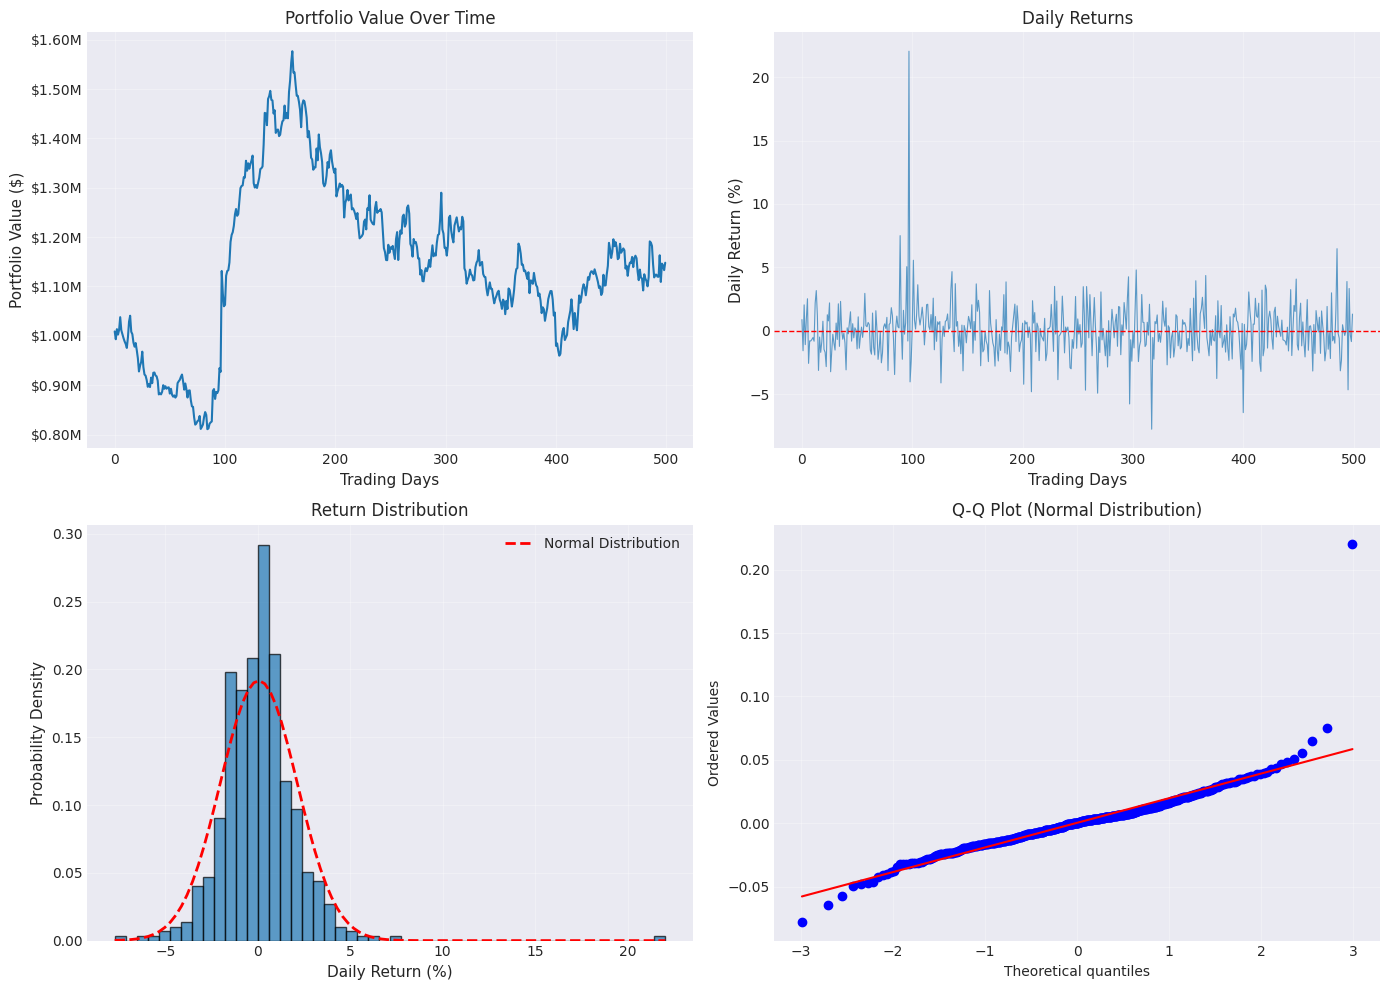

In [3]:
# Visualize returns and portfolio value
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Portfolio value over time
ax1.plot(portfolio_value, linewidth=1.5)
ax1.set_xlabel("Trading Days", fontsize=11)
ax1.set_ylabel("Portfolio Value ($)", fontsize=11)
ax1.set_title("Portfolio Value Over Time", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x/1e6:.2f}M"))

# Daily returns
ax2.plot(returns * 100, linewidth=0.8, alpha=0.7)
ax2.axhline(y=0, color="r", linestyle="--", linewidth=1)
ax2.set_xlabel("Trading Days", fontsize=11)
ax2.set_ylabel("Daily Return (%)", fontsize=11)
ax2.set_title("Daily Returns", fontsize=12)
ax2.grid(True, alpha=0.3)

# Return distribution
ax3.hist(returns * 100, bins=50, density=True, alpha=0.7, edgecolor="black")
x_range = np.linspace(returns.min() * 100, returns.max() * 100, 100)
ax3.plot(
    x_range,
    stats.norm.pdf(x_range, returns.mean() * 100, returns.std() * 100),
    "r--",
    linewidth=2,
    label="Normal Distribution",
)
ax3.set_xlabel("Daily Return (%)", fontsize=11)
ax3.set_ylabel("Probability Density", fontsize=11)
ax3.set_title("Return Distribution", fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(returns, dist="norm", plot=ax4)
ax4.set_title("Q-Q Plot (Normal Distribution)", fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Value at Risk (VaR) Calculation

Calculate VaR using three different methods.

In [4]:
# Initialize risk metrics calculator
risk_metrics = RiskMetrics()
confidence_level = 0.95  # 95% confidence
portfolio_value_current = portfolio_value[-1]

# 1. Historical Simulation VaR
var_historical_result = risk_metrics.var(returns, confidence_level, method="historical")
var_historical = var_historical_result["var"]
var_historical_dollar = var_historical * portfolio_value_current

# 2. Parametric VaR (Variance-Covariance)
var_parametric_result = risk_metrics.var(returns, confidence_level, method="parametric")
var_parametric = var_parametric_result["var"]
var_parametric_dollar = var_parametric * portfolio_value_current

# 3. Monte Carlo VaR (requires distribution parameters)
returns_mean = float(returns.mean())
returns_std = float(returns.std(ddof=1))
var_monte_carlo_result = risk_metrics.var(
    confidence_level=confidence_level,
    method="monte_carlo",
    mean=returns_mean,
    std_dev=returns_std,
    num_simulations=10000,
    seed=42,
)
var_monte_carlo = var_monte_carlo_result["var"]
var_monte_carlo_dollar = var_monte_carlo * portfolio_value_current

print(f"Value at Risk (VaR) at {confidence_level*100:.0f}% confidence:")
print()
print("Historical Simulation:")
print(f"  VaR: {var_historical*100:.3f}% or ${abs(var_historical_dollar):,.0f}")
print()
print("Parametric (Variance-Covariance):")
print(f"  VaR: {var_parametric*100:.3f}% or ${abs(var_parametric_dollar):,.0f}")
print()
print("Monte Carlo:")
print(f"  VaR: {var_monte_carlo*100:.3f}% or ${abs(var_monte_carlo_dollar):,.0f}")
print()
print(
    f"Interpretation: We are {confidence_level*100:.0f}% confident that daily losses will not exceed these amounts."
)

Value at Risk (VaR) at 95% confidence:

Historical Simulation:
  VaR: 2.845% or $32,663

Parametric (Variance-Covariance):
  VaR: 3.376% or $38,756

Monte Carlo:
  VaR: 3.388% or $38,903

Interpretation: We are 95% confident that daily losses will not exceed these amounts.


### Compare VaR Methods

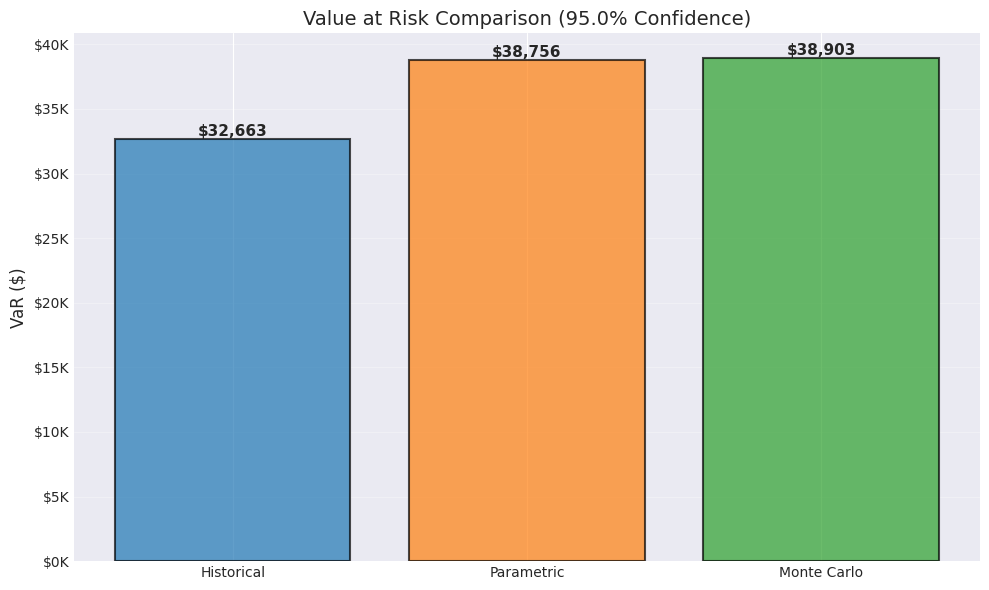

In [5]:
# Create comparison visualization
var_methods = ["Historical", "Parametric", "Monte Carlo"]
var_values = [abs(var_historical_dollar), abs(var_parametric_dollar), abs(var_monte_carlo_dollar)]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    var_methods,
    var_values,
    color=["#1f77b4", "#ff7f0e", "#2ca02c"],
    alpha=0.7,
    edgecolor="black",
    linewidth=1.5,
)
ax.set_ylabel("VaR ($)", fontsize=12)
ax.set_title(f"Value at Risk Comparison ({confidence_level*100}% Confidence)", fontsize=14)
ax.grid(True, alpha=0.3, axis="y")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x/1000:.0f}K"))

# Add value labels
for bar, value in zip(bars, var_values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

## 3. Conditional VaR (CVaR / Expected Shortfall)

CVaR measures the expected loss given that the loss exceeds VaR.

In [6]:
# Calculate CVaR
cvar_result = risk_metrics.cvar(returns, confidence_level)
cvar_historical = cvar_result["cvar"]
cvar_dollar = cvar_historical * portfolio_value_current

print(f"Conditional VaR (CVaR) at {confidence_level*100:.0f}% confidence:")
print(f"CVaR: {cvar_historical*100:.3f}% or ${abs(cvar_dollar):,.0f}")
print()
print("Comparison:")
print(f"VaR (95%):  ${abs(var_historical_dollar):,.0f}")
print(f"CVaR (95%): ${abs(cvar_dollar):,.0f}")
print()
print(f"CVaR is {abs(cvar_dollar)/abs(var_historical_dollar):.2f}x larger than VaR")
print()
print(
    f"Interpretation: If losses exceed the VaR threshold, the expected loss is ${abs(cvar_dollar):,.0f}"
)

Conditional VaR (CVaR) at 95% confidence:
CVaR: 3.940% or $45,233

Comparison:
VaR (95%):  $32,663
CVaR (95%): $45,233

CVaR is 1.38x larger than VaR

Interpretation: If losses exceed the VaR threshold, the expected loss is $45,233


### Visualize VaR and CVaR on Return Distribution

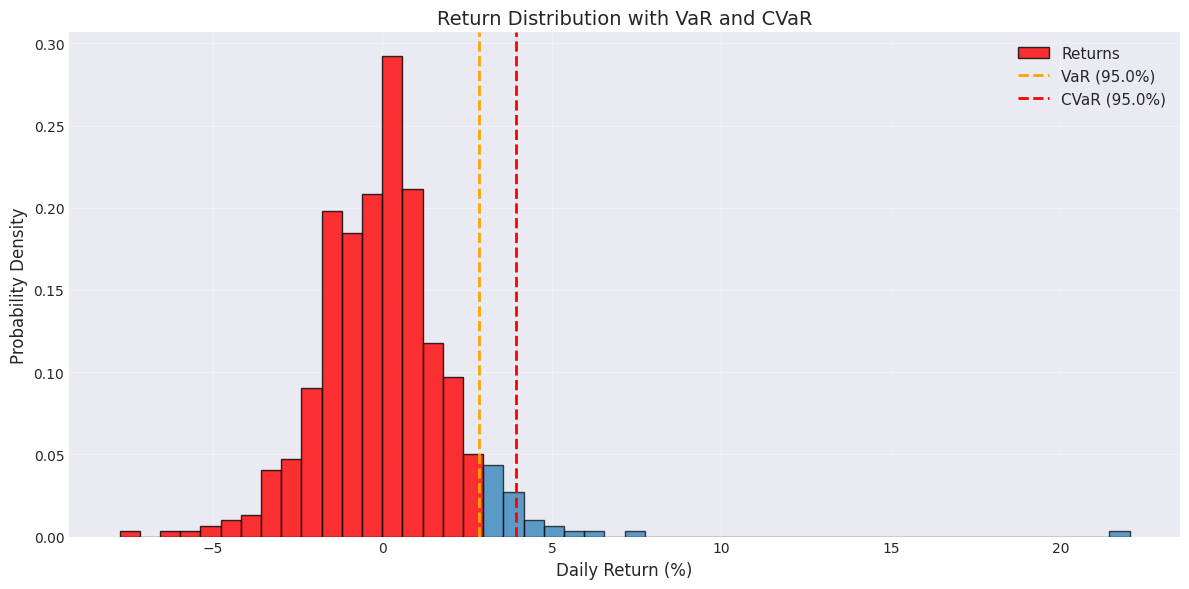

In [7]:
# Plot return distribution with VaR and CVaR
fig, ax = plt.subplots(figsize=(12, 6))

# Histogram
n, bins, patches = ax.hist(
    returns * 100, bins=50, density=True, alpha=0.7, edgecolor="black", label="Returns"
)

# Highlight tail beyond VaR
var_threshold = var_historical * 100
for i, patch in enumerate(patches):
    if bins[i] < var_threshold:
        patch.set_facecolor("red")
        patch.set_alpha(0.8)

# Add VaR and CVaR lines
ax.axvline(
    x=var_threshold,
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"VaR ({confidence_level*100}%)",
)
ax.axvline(
    x=cvar_historical * 100,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"CVaR ({confidence_level*100}%)",
)

ax.set_xlabel("Daily Return (%)", fontsize=12)
ax.set_ylabel("Probability Density", fontsize=12)
ax.set_title("Return Distribution with VaR and CVaR", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Portfolio Greeks Calculation

Calculate Greeks for a portfolio of options.

In [8]:
# Define a portfolio of options
bs_model = BlackScholesModel()
greeks_calc = GreeksCalculator()

# Portfolio positions
positions = [
    {
        "spot": 100,
        "strike": 95,
        "rate": 0.05,
        "dividend": 0.02,
        "volatility": 0.25,
        "time": 0.5,
        "type": "call",
        "quantity": 100,
    },
    {
        "spot": 100,
        "strike": 100,
        "rate": 0.05,
        "dividend": 0.02,
        "volatility": 0.25,
        "time": 0.5,
        "type": "call",
        "quantity": -50,
    },
    {
        "spot": 100,
        "strike": 105,
        "rate": 0.05,
        "dividend": 0.02,
        "volatility": 0.25,
        "time": 0.5,
        "type": "call",
        "quantity": 100,
    },
    {
        "spot": 100,
        "strike": 100,
        "rate": 0.05,
        "dividend": 0.02,
        "volatility": 0.25,
        "time": 1.0,
        "type": "put",
        "quantity": 75,
    },
]

# Calculate individual Greeks and aggregate
portfolio_greeks = {"delta": 0, "gamma": 0, "vega": 0, "theta": 0, "rho": 0}
portfolio_value_options = 0

print("Individual Position Greeks:")
print("=" * 90)
for i, pos in enumerate(positions, 1):
    greeks = bs_model.greeks(
        pos["spot"],
        pos["strike"],
        pos["rate"],
        pos["dividend"],
        pos["volatility"],
        pos["time"],
        pos["type"],
    )
    price = bs_model.price(
        pos["spot"],
        pos["strike"],
        pos["rate"],
        pos["dividend"],
        pos["volatility"],
        pos["time"],
        pos["type"],
    )

    # Scale by quantity
    position_value = price * pos["quantity"]
    portfolio_value_options += position_value

    print()
    print(
        f"Position {i}: {pos['quantity']:+4d} {pos['type'].upper()} @ K={pos['strike']}, T={pos['time']}"
    )
    print(f"  Price: ${price:.4f} | Position Value: ${position_value:,.2f}")
    print(
        f"  Delta: {greeks['delta']*pos['quantity']:+8.2f} | Gamma: {greeks['gamma']*pos['quantity']:+8.4f}"
    )
    print(
        f"  Vega:  {greeks['vega']*pos['quantity']:+8.2f} | Theta: {greeks['theta']*pos['quantity']:+8.2f}"
    )

    # Aggregate
    for greek in portfolio_greeks:
        portfolio_greeks[greek] += greeks[greek] * pos["quantity"]

print()
print("=" * 90)
print()
print("Portfolio Summary:")
print(f"Total Portfolio Value: ${portfolio_value_options:,.2f}")
print()
print("Aggregated Greeks:")
print(f"  Delta: {portfolio_greeks['delta']:+.2f}")
print(f"  Gamma: {portfolio_greeks['gamma']:+.4f}")
print(f"  Vega:  {portfolio_greeks['vega']:+.2f}")
print(f"  Theta: {portfolio_greeks['theta']:+.2f}")
print(f"  Rho:   {portfolio_greeks['rho']:+.2f}")

Individual Position Greeks:

Position 1: +100 CALL @ K=95, T=0.5
  Price: $10.3924 | Position Value: $1,039.24
  Delta:   +67.17 | Gamma:  +2.0068
  Vega:    +25.09 | Theta:    -1.31

Position 2:  -50 CALL @ K=100, T=0.5
  Price: $7.6830 | Position Value: $-384.15
  Delta:   -28.16 | Gamma:  -1.1005
  Vega:    -13.76 | Theta:    +0.76

Position 3: +100 CALL @ K=105, T=0.5
  Price: $5.5205 | Position Value: $552.05
  Delta:   +45.45 | Gamma:  +2.2225
  Vega:    +27.78 | Theta:    -1.60

Position 4:  +75 PUT @ K=100, T=1.0
  Price: $8.2268 | Position Value: $617.01
  Delta:   -29.64 | Gamma:  +1.1384
  Vega:    +28.46 | Theta:    -1.30


Portfolio Summary:
Total Portfolio Value: $1,824.15

Aggregated Greeks:
  Delta: +54.82
  Gamma: +4.2673
  Vega:  +67.57
  Theta: -3.45
  Rho:   +0.38


### Visualize Portfolio Greeks

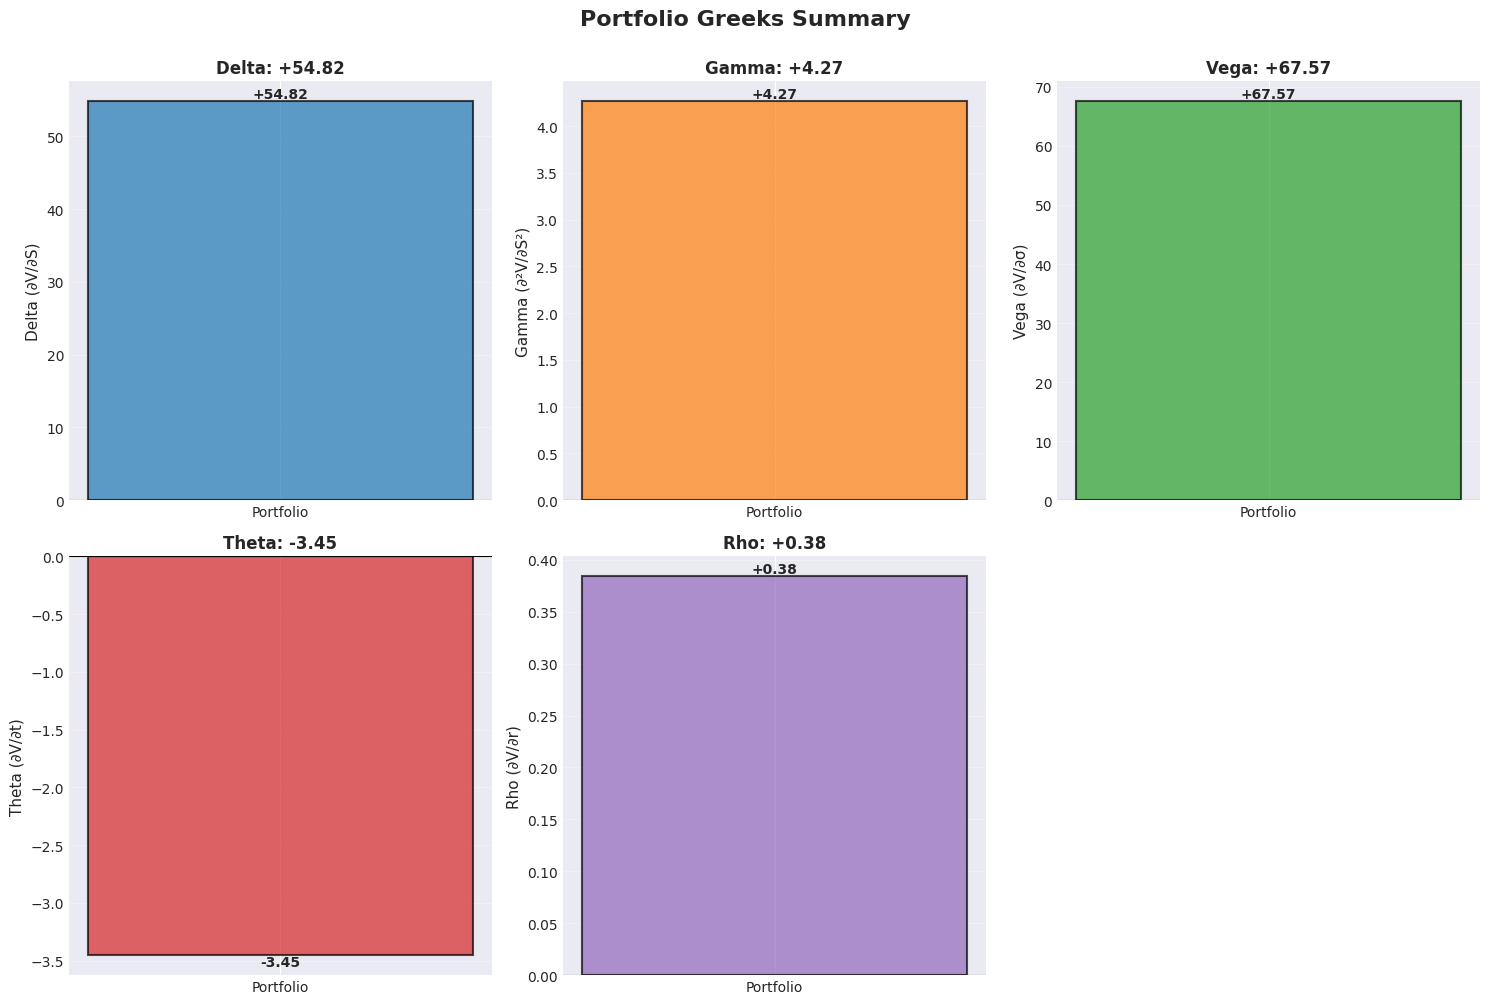

In [9]:
# Create Greeks visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

greek_names = ["delta", "gamma", "vega", "theta", "rho"]
greek_labels = ["Delta (∂V/∂S)", "Gamma (∂²V/∂S²)", "Vega (∂V/∂σ)", "Theta (∂V/∂t)", "Rho (∂V/∂r)"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

for idx, (greek, label, color) in enumerate(zip(greek_names, greek_labels, colors)):
    ax = axes[idx]
    value = portfolio_greeks[greek]

    # Bar chart
    bar = ax.bar(["Portfolio"], [value], color=color, alpha=0.7, edgecolor="black", linewidth=1.5)
    ax.axhline(y=0, color="black", linestyle="-", linewidth=0.8)
    ax.set_ylabel(label, fontsize=11)
    ax.set_title(f'{label.split(" ")[0]}: {value:+.2f}', fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3, axis="y")

    # Add value label
    height = bar[0].get_height()
    ax.text(
        bar[0].get_x() + bar[0].get_width() / 2.0,
        height,
        f"{value:+.2f}",
        ha="center",
        va="bottom" if value > 0 else "top",
        fontsize=10,
        fontweight="bold",
    )

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle("Portfolio Greeks Summary", fontsize=16, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

## 5. Risk Metrics and Stress Testing

Analyze additional risk metrics and perform stress tests.

In [10]:
# Calculate additional risk metrics
sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
sortino_ratio = (returns.mean() * 252) / (returns[returns < 0].std() * np.sqrt(252))
max_drawdown = (
    (portfolio_value - np.maximum.accumulate(portfolio_value))
    / np.maximum.accumulate(portfolio_value)
).min()

# Calculate rolling volatility
rolling_window = 30
rolling_vol = pd.Series(returns).rolling(window=rolling_window).std() * np.sqrt(252)

print("Risk Metrics:")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Sortino Ratio: {sortino_ratio:.3f}")
print(f"Maximum Drawdown: {max_drawdown*100:.2f}%")
print(f"Current Volatility (30-day): {rolling_vol.iloc[-1]*100:.2f}%")

Risk Metrics:
Sharpe Ratio: 0.371
Sortino Ratio: 0.661
Maximum Drawdown: -39.12%
Current Volatility (30-day): 35.66%


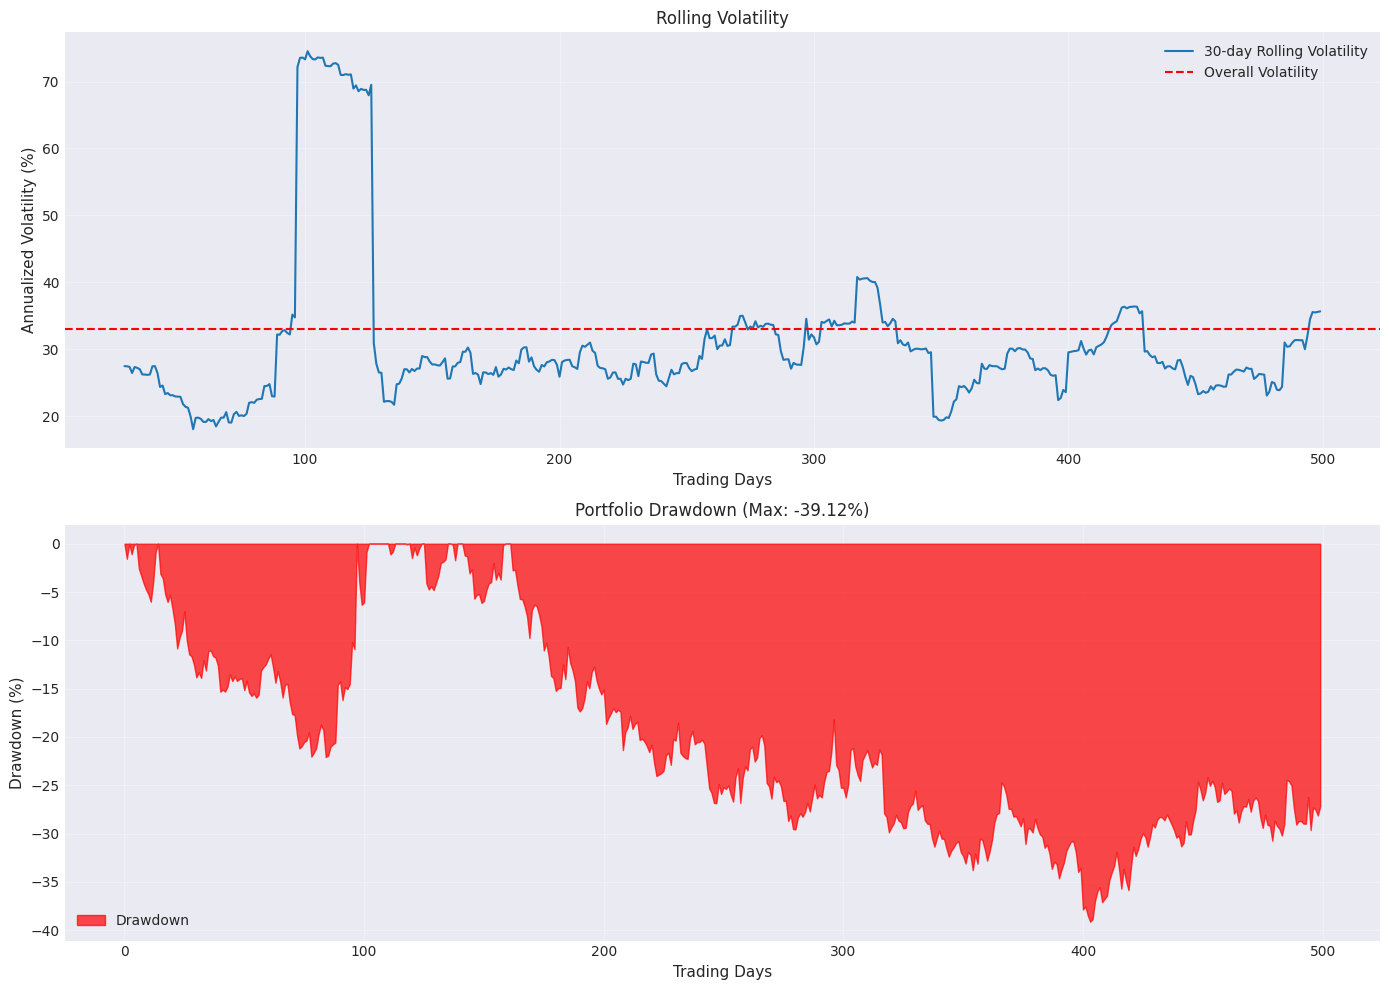

In [11]:
# Visualize rolling volatility and drawdown
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Rolling volatility
ax1.plot(rolling_vol * 100, linewidth=1.5, label=f"{rolling_window}-day Rolling Volatility")
ax1.axhline(
    y=returns.std() * np.sqrt(252) * 100,
    color="r",
    linestyle="--",
    linewidth=1.5,
    label="Overall Volatility",
)
ax1.set_xlabel("Trading Days", fontsize=11)
ax1.set_ylabel("Annualized Volatility (%)", fontsize=11)
ax1.set_title("Rolling Volatility", fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Drawdown
running_max = np.maximum.accumulate(portfolio_value)
drawdown = (portfolio_value - running_max) / running_max * 100
ax2.fill_between(range(len(drawdown)), drawdown, 0, alpha=0.7, color="red", label="Drawdown")
ax2.set_xlabel("Trading Days", fontsize=11)
ax2.set_ylabel("Drawdown (%)", fontsize=11)
ax2.set_title(f"Portfolio Drawdown (Max: {max_drawdown*100:.2f}%)", fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Stress Testing

Simulate extreme market scenarios.

In [12]:
# Define stress scenarios
stress_scenarios = {
    "Market Crash (-20%)": -0.20,
    "Severe Correction (-10%)": -0.10,
    "Moderate Decline (-5%)": -0.05,
    "Normal Day": 0.0,
    "Rally (+5%)": 0.05,
    "Strong Rally (+10%)": 0.10,
}

# Calculate portfolio impact for each scenario
print("Stress Test Results:")
print("=" * 70)
print(f"{'Scenario':<30} {'Spot Change':<15} {'Portfolio Impact':<20}")
print("=" * 70)

stress_results = []
for scenario, spot_change in stress_scenarios.items():
    # Approximate P&L using Delta
    spot_move = 100 * spot_change
    pnl = portfolio_greeks["delta"] * spot_move
    pnl_pct = (pnl / portfolio_value_options) * 100 if portfolio_value_options != 0 else 0

    stress_results.append(
        {"scenario": scenario, "change": spot_change * 100, "pnl": pnl, "pnl_pct": pnl_pct}
    )
    print(f"{scenario:<30} {spot_change*100:>+6.1f}% {pnl:>+12,.2f} ({pnl_pct:>+6.2f}%)")

print("=" * 70)
print()
print("Note: Stress test uses Delta approximation (linear). Actual P&L includes Gamma effects.")

Stress Test Results:
Scenario                       Spot Change     Portfolio Impact    
Market Crash (-20%)             -20.0%    -1,096.46 (-60.11%)
Severe Correction (-10%)        -10.0%      -548.23 (-30.05%)
Moderate Decline (-5%)           -5.0%      -274.12 (-15.03%)
Normal Day                       +0.0%        +0.00 ( +0.00%)
Rally (+5%)                      +5.0%      +274.12 (+15.03%)
Strong Rally (+10%)             +10.0%      +548.23 (+30.05%)

Note: Stress test uses Delta approximation (linear). Actual P&L includes Gamma effects.


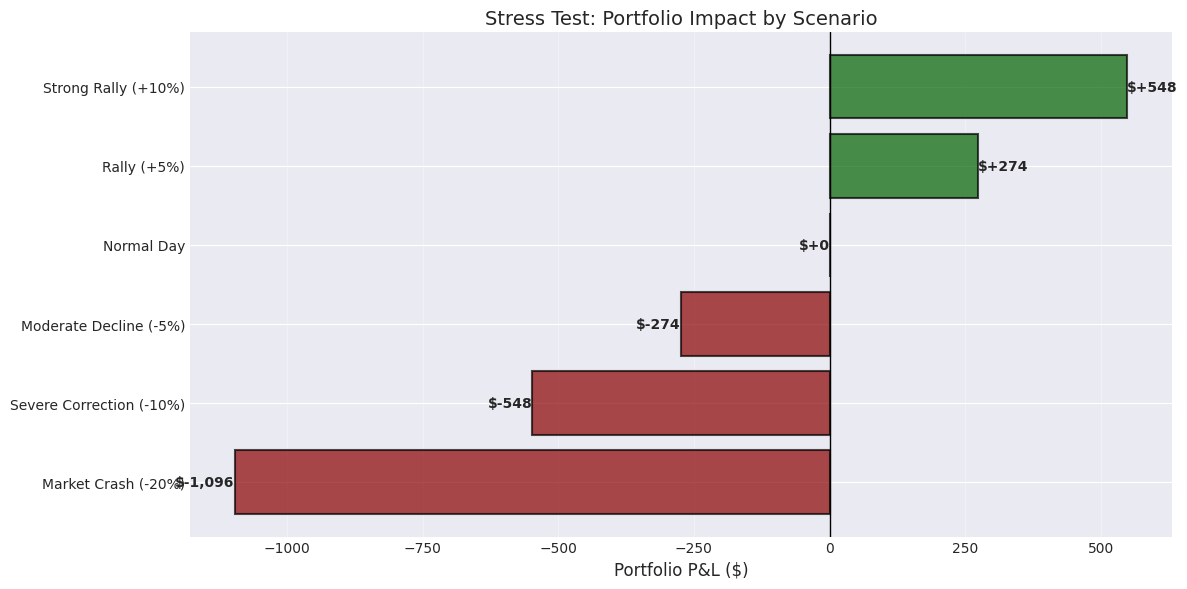

In [13]:
# Visualize stress test results
stress_df = pd.DataFrame(stress_results)

fig, ax = plt.subplots(figsize=(12, 6))
colors = ["darkred" if x < 0 else "darkgreen" for x in stress_df["pnl"]]
bars = ax.barh(
    stress_df["scenario"],
    stress_df["pnl"],
    color=colors,
    alpha=0.7,
    edgecolor="black",
    linewidth=1.5,
)
ax.axvline(x=0, color="black", linestyle="-", linewidth=1)
ax.set_xlabel("Portfolio P&L ($)", fontsize=12)
ax.set_title("Stress Test: Portfolio Impact by Scenario", fontsize=14)
ax.grid(True, alpha=0.3, axis="x")

# Add value labels
for bar, pnl in zip(bars, stress_df["pnl"]):
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2.0,
        f"${pnl:+,.0f}",
        ha="left" if width > 0 else "right",
        va="center",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

## 6. VaR Backtesting

Validate VaR model accuracy by comparing predictions to actual outcomes.

In [14]:
# Backtest VaR model
lookback_window = 250  # Use 1 year of data for VaR calculation
var_violations = []
var_estimates = []

for i in range(lookback_window, len(returns)):
    # Calculate VaR using historical data
    historical_returns = returns[i - lookback_window : i]
    var_estimate = risk_metrics.var(historical_returns, confidence_level, method="historical")[
        "var"
    ]
    var_estimates.append(var_estimate)

    # Check if actual return violated VaR
    actual_return = returns[i]
    violation = 1 if actual_return < var_estimate else 0
    var_violations.append(violation)

# Calculate violation rate
violation_rate = np.mean(var_violations)
expected_rate = 1 - confidence_level

print("VaR Backtesting Results:")
print(f"Test Period: {len(var_violations)} days")
print(f"Expected Violation Rate: {expected_rate*100:.1f}%")
print(f"Actual Violation Rate: {violation_rate*100:.2f}%")
print(f"Number of Violations: {sum(var_violations)}")
print()
print("Model Assessment: ", end="")
if abs(violation_rate - expected_rate) < 0.02:
    print("✓ VaR model is well-calibrated")
elif violation_rate > expected_rate:
    print("⚠ VaR model underestimates risk (too many violations)")
else:
    print("⚠ VaR model overestimates risk (too few violations)")

VaR Backtesting Results:
Test Period: 250 days
Expected Violation Rate: 5.0%
Actual Violation Rate: 93.20%
Number of Violations: 233

Model Assessment: ⚠ VaR model underestimates risk (too many violations)


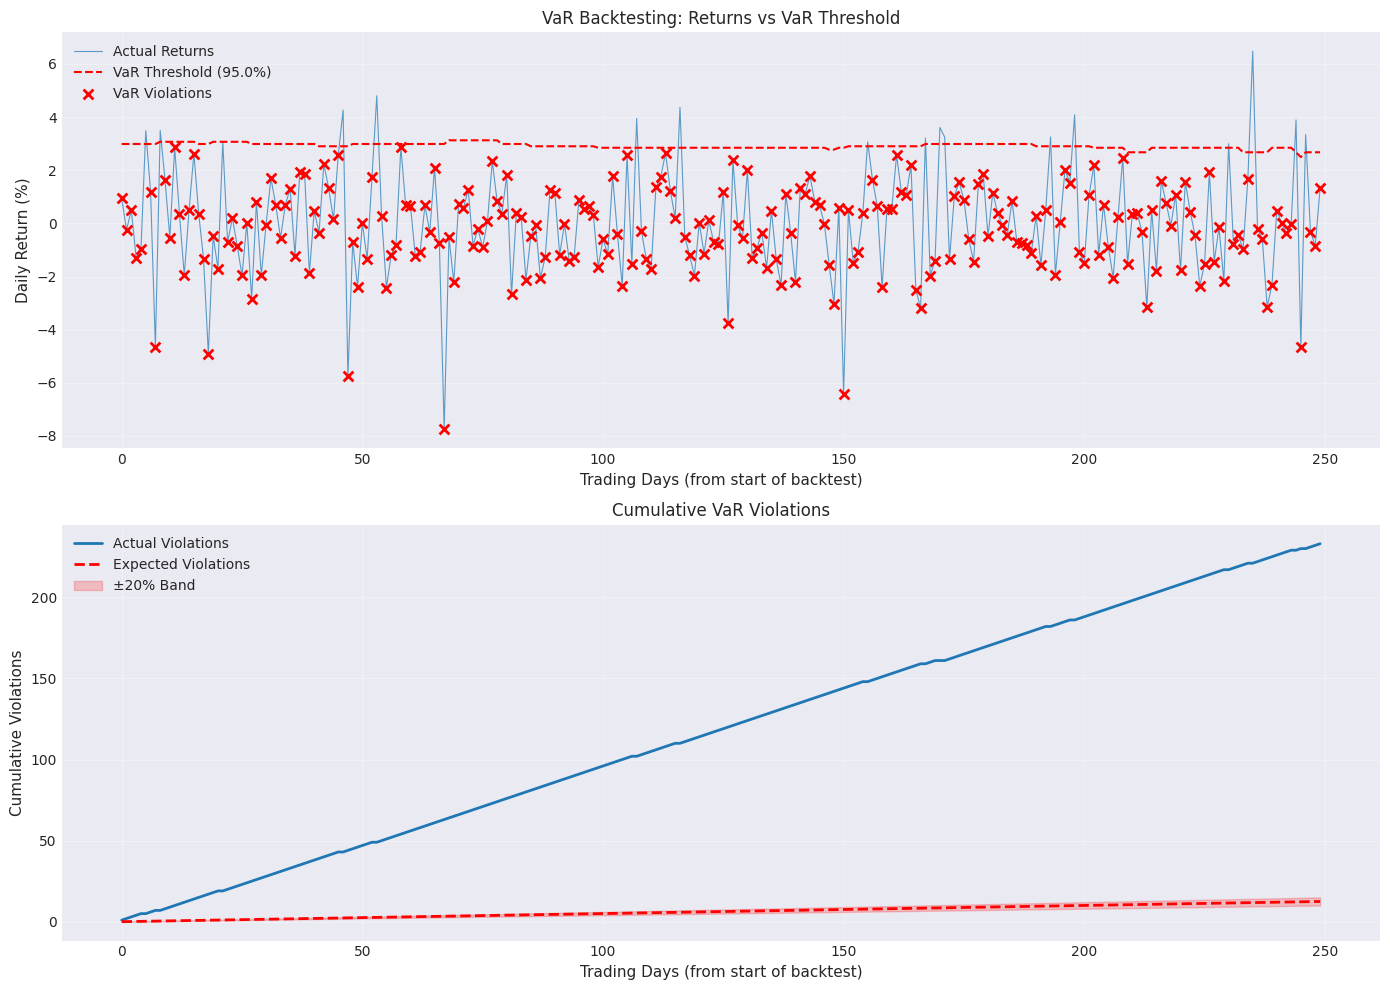

In [15]:
# Visualize VaR backtesting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Returns vs VaR threshold
test_returns = returns[lookback_window:]
ax1.plot(test_returns * 100, linewidth=0.8, alpha=0.7, label="Actual Returns")
ax1.plot(
    np.array(var_estimates) * 100,
    "r--",
    linewidth=1.5,
    label=f"VaR Threshold ({confidence_level*100}%)",
)

# Highlight violations
violation_indices = [i for i, v in enumerate(var_violations) if v == 1]
ax1.scatter(
    violation_indices,
    [test_returns[i] * 100 for i in violation_indices],
    color="red",
    s=50,
    zorder=5,
    label="VaR Violations",
    marker="x",
    linewidths=2,
)

ax1.set_xlabel("Trading Days (from start of backtest)", fontsize=11)
ax1.set_ylabel("Daily Return (%)", fontsize=11)
ax1.set_title("VaR Backtesting: Returns vs VaR Threshold", fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Cumulative violations
cumulative_violations = np.cumsum(var_violations)
expected_violations = np.arange(1, len(var_violations) + 1) * expected_rate

ax2.plot(cumulative_violations, linewidth=2, label="Actual Violations")
ax2.plot(expected_violations, "r--", linewidth=2, label="Expected Violations")
ax2.fill_between(
    range(len(expected_violations)),
    expected_violations * 0.8,
    expected_violations * 1.2,
    alpha=0.2,
    color="red",
    label="±20% Band",
)
ax2.set_xlabel("Trading Days (from start of backtest)", fontsize=11)
ax2.set_ylabel("Cumulative Violations", fontsize=11)
ax2.set_title("Cumulative VaR Violations", fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Key Takeaways**:
- Use multiple VaR methods for robust risk assessment
- CVaR provides better tail risk information than VaR
- Portfolio Greeks are essential for managing options positions
- Regular backtesting ensures risk models remain accurate
- Stress testing reveals portfolio vulnerabilities